In [212]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
#from matplotlib.patches import Ellipse
from matplotlib.cm import ScalarMappable
#from matplotlib.patheffects import withStroke
#import matplotlib.ticker as ticker

#import math
#import csv
#from math import pi
#import pandas as pd
#import glob
#import match 

#import seaborn as sns
#import statistics as stat

#from scipy.stats import kde #for the plot very soft
#from scipy.stats import gaussian_kde
#from sklearn.neighbors import KernelDensity

from astropy.io import fits
from astropy.table import Table, unique, join, vstack, QTable, hstack
#from astropy.visualization import astropy_mpl_style
#from astropy.visualization import simple_norm
#from astropy.visualization import make_lupton_rgb
#from astropy.visualization import SqrtStretch
#from astropy.visualization import ZScaleInterval


from astropy.stats import biweight_location, biweight_scale
#from astropy.nddata import Cutout2D
from astropy import units as u
from astropy import constants as Cons
from astropy.wcs import WCS
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, Galactic, Angle

#
#plt.rcParams['text.usetex'] = True
#plt.rcParams['xtick.direction'] = 'in'
#plt.rcParams['ytick.direction'] = 'in'
#
#plt.rcParams['axes.linewidth'] = 1.5
#plt.rcParams['xtick.major.size'] = 6
#plt.rcParams['xtick.minor.size'] = 3
#plt.rcParams['ytick.major.size'] = 6
#plt.rcParams['ytick.minor.size'] = 3

In [91]:
def peculiar_velocity(z_gal, cz):
    c = Cons.c.to('km s-1')
    vel = ( (z_gal - cz)/(1-cz) ) * c
    #Danesse, L., de Zotti, G., & di Tullio, G. 1990, A&A, 82, 322
    return vel
    

In [93]:
cosmo = FlatLambdaCDM(H0=68.3, Om0=0.299)

t = Table.read('Campo_ComaCluster_TP2024_Topicos.dat', format='ascii')

#### Determinar las galaxias miembro del cúmulo de Coma. Para esto considerar valores adecuados de distancia proyectada (rp) y diferencia de velocidad radial (dV) de las galaxias respecto al centro del cúmulo cuyas coordenadas son alfaC=194.9531°, deltaC= 27.9807° J2000; y el redshift zC=0.0231.
#### Tener en cuenta que el radio de un cúmulo masivo es de alrededor de 1,5Mpc, y la diferencia de dispersión de velocidades del orden de 1000 km/s

In [95]:
coma_center = SkyCoord(ra=194.9531*u.deg, dec=27.9807*u.deg)
R_P = 3.5*u.Mpc

#t['rp_'] = t['rp']*u.Mpc.to(u.kpc)
c_ra = coma_center.ra
c_de = coma_center.dec

c_z = 0.0231 * cu.redshift
d = c_z.to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving"))

#-------histtype='step'
t['Galaxy_Type'] = ['Early' if c > 2.6 else 'Late' for c in t['C']]

In [96]:
t_cat = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
pa = coma_center.position_angle(t_cat)
sep = coma_center.separation(t_cat).to(u.arcsec)

d_A = cosmo.angular_diameter_distance(z=c_z)
distance_Mpc = (sep*d_A).to(u.Mpc, u.dimensionless_angles())
t['X_'] = distance_Mpc*np.sin(pa)
t['Y_'] = distance_Mpc*np.cos(pa)
t['DIST_PROY'] = distance_Mpc

t['V_pec'] = peculiar_velocity(t['z'], c_z)

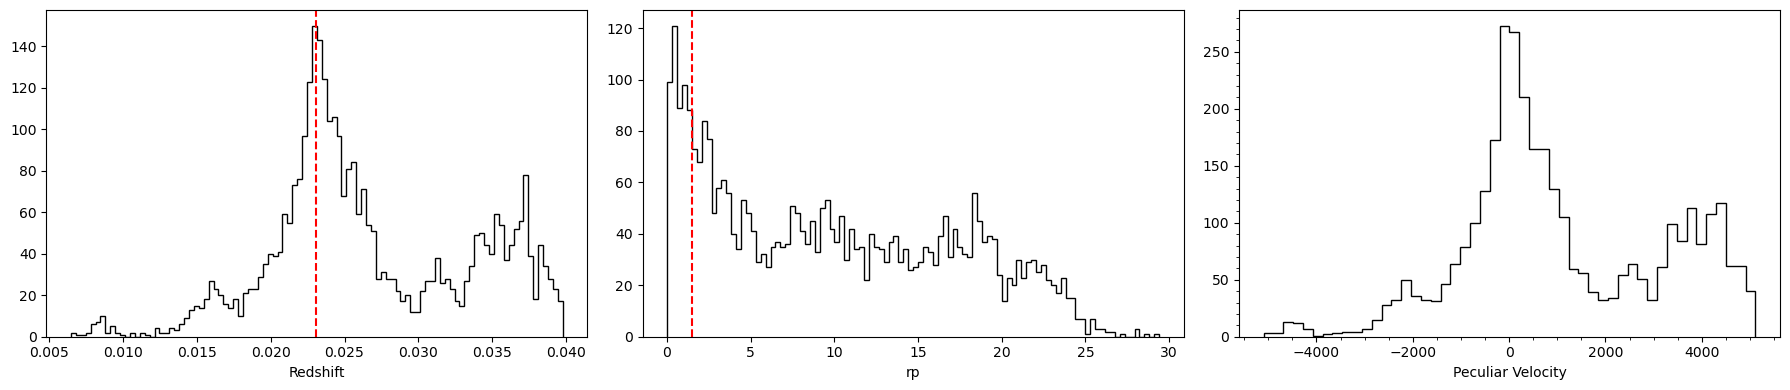

In [97]:
# Crear la figura y los subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.hist(t['z'], bins=100, fc='black', ec='black', histtype='step')
ax1.axvline(c_z, color='red', linestyle='--')
ax1.set_xlabel('Redshift')
#ax1.set_ylabel('Count')

ax2.hist(t['rp'], bins=100, fc='black', ec='black', histtype='step')
ax2.axvline(1.5, color='red', linestyle='--')
#ax2.axvline(c_z, color='red', linestyle='--')
ax2.set_xlabel('rp')

ax3.hist(t['V_pec'], bins=50, fc='black', ec='black', histtype='step')
ax3.set_xlabel('Peculiar Velocity')
ax3.minorticks_on()

plt.tight_layout()
plt.show()


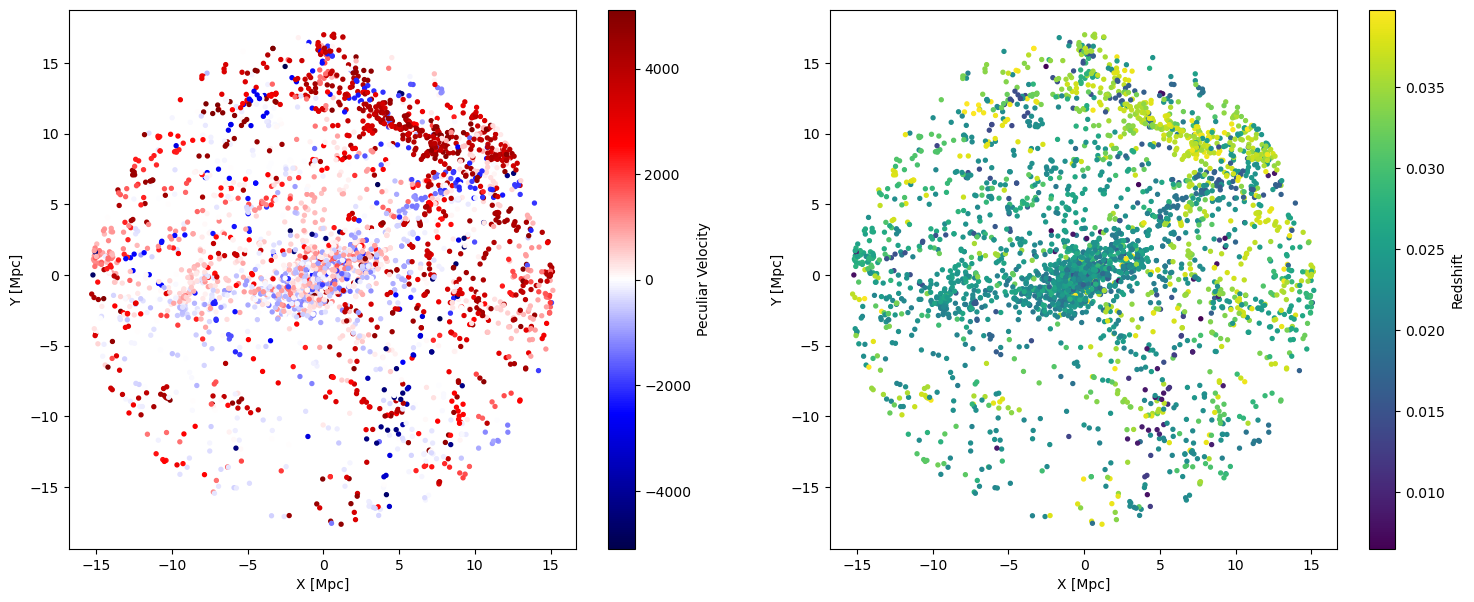

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,7)) 

sc1 = ax1.scatter(t['X_'], t['Y_'], c=t['V_pec'], s=8, cmap='seismic')
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Peculiar Velocity')
ax1.set_xlabel('X [Mpc]')
ax1.set_ylabel('Y [Mpc]')

sc2 = ax2.scatter(t['X_'], t['Y_'], c=t['z'], s=8, cmap='viridis')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Redshift')
ax2.set_xlabel('X [Mpc]')
ax2.set_ylabel('Y [Mpc]')

plt.show()

#### Encontrar miembros del cúmulos:
##### REalizar un corte inicial que excluya la otra estructura del fondo (filamento). Incluir también la otra estructura


In [100]:
c1 = t[t['rp']<5]
c1 = c1[c1['dV']<5000]

z_peak = c_z.copy()
for i in range(3):
    z_peak = biweight_location(c1['z'], M=np.array([z_peak]))

##sigma clippng
s = 3
while True:
    z_peak = biweight_location(c1['z'], M=np.array([z_peak]))
    c1.remove_column('V_pec')
    c1['V_pec'] = peculiar_velocity(c1['z'], z_peak)
    sigma_bi = biweight_scale(c1['V_pec'], M=np.array([0.0]))       #---Sigma Biweight
    c1.sort('V_pec')                                    #-----------------Sigma Gapper Hou et al. 2009
    n = len(c1)

    rej = c1[abs(c1['V_pec']) >= (s*sigma_bi)]   #----rejected_galaxies
    if len(rej) == 0:      #---when there are no rejected galaxies end the iteration and calculate sigma error
        sigma_err = 0.92*sigma_bi/np.sqrt(len(c1)-1)    #Ruel, J., Bazin, G., Bayliss, M., et al. 2014, ApJ, 792, 45
        #print("NUMBER OF ITERATIONS: "+cont)
        break
    c1 = c1[abs(c1['V_pec']) <= (s*sigma_bi)]  #---if len(rej)!=0 then cut in s*sigma and start over again 
#zcl,bias,zcl_err,zcl_conf = st.jackknife_stats(clip["col13"]/c,st.biweight_location)  #--calculate final zcl removing bias, estimating std_err and update peculiar velocities
#zcl_err = (((sigma/c)*(1+zcl))/np.sqrt(len(clip))     #ruel standard error
#zcl_conf= 0
#print(str(sigma_bi)+" : "+str(sigma_g))
#c1_err = np.std(c1['z'])/np.sqrt(len(c1))   #standard error
#zcl_err = (zcl_conf[1] - zcl_conf[0])/2
#t.remove_column("PEC_VEL")
t['V_pec'] = peculiar_velocity(t['z'], z_peak)


clip = t[abs(t['V_pec']) <= (3*sigma_bi)]


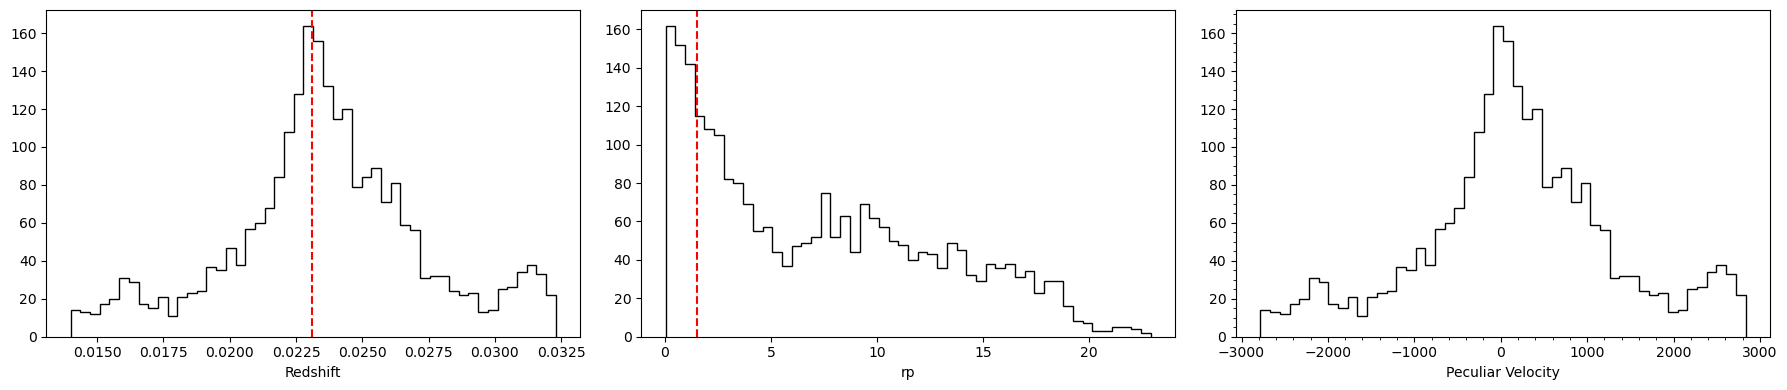

In [101]:
# Crear la figura y los subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.hist(clip['z'], bins=50, fc='black', ec='black', histtype='step')
ax1.axvline(c_z, color='red', linestyle='--')
ax1.set_xlabel('Redshift')
#ax1.set_ylabel('Count')

ax2.hist(clip['rp'], bins=50, fc='black', ec='black', histtype='step')
ax2.axvline(1.5, color='red', linestyle='--')
#ax2.axvline(c_z, color='red', linestyle='--')
ax2.set_xlabel('rp')

ax3.hist(clip['V_pec'], bins=50, fc='black', ec='black', histtype='step')
ax3.set_xlabel('Peculiar Velocity')
ax3.minorticks_on()

plt.tight_layout()
plt.show()


Text(0.5, 0, 'Y [Mpc]')

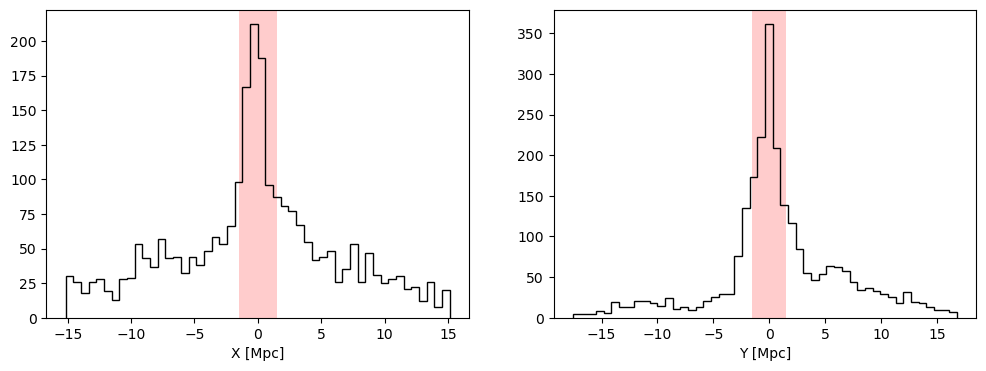

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

h=ax1.hist(clip['X_'], bins=50, fc='black', ec='black', histtype='step')
ax1.axvspan(-1.5, 1.5, facecolor='red', alpha=0.2)
#ax1.axvline(c_z, color='red', linestyle='--')
ax1.set_xlabel('X [Mpc]')

h=ax2.hist(clip['Y_'], bins=50, fc='black', ec='black', histtype='step')
ax2.axvspan(-1.5, 1.5, facecolor='red', alpha=0.2)
ax2.set_xlabel('Y [Mpc]')

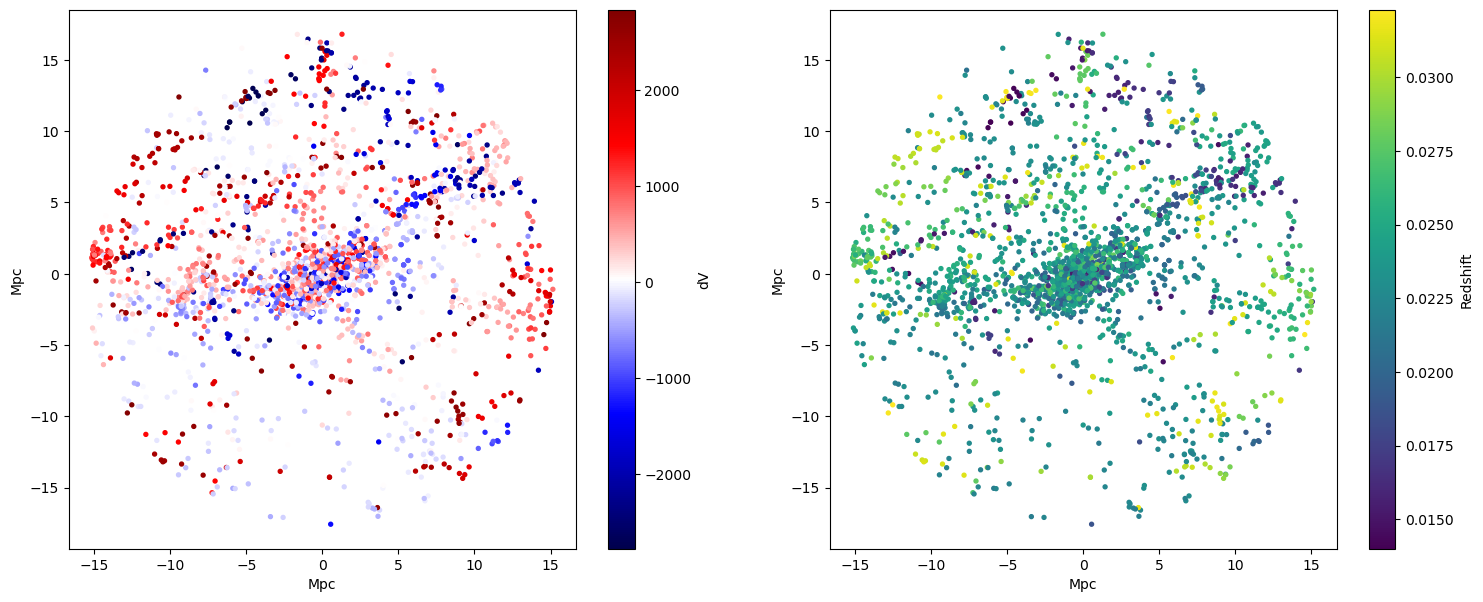

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,7)) 

sc1 = ax1.scatter(clip['X_'], clip['Y_'], c=clip['V_pec'], s=8, cmap='seismic')
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('dV')
ax1.set_xlabel('Mpc')
ax1.set_ylabel('Mpc')

sc2 = ax2.scatter(clip['X_'], clip['Y_'], c=clip['z'], s=8, cmap='viridis')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Redshift')
ax2.set_xlabel('Mpc')
ax2.set_ylabel('Mpc')

plt.show()

In [104]:
tc = clip[clip['rp']<3.5]
#tc = tc[tc['dV'] < 3*sigma_bi]

tc1 = tc[tc['rp']<1.5]
len(tc1)

483

#### 2) Realizar un análisis de las distintas propiedades de las galaxias miembro del cúmulo tales como:
- índice de color (Mg-Mr)
- tasa de formación estelar específica logSSFR
- parámetro de edad de poblaciones estelares dn(4000)
- índice de concentración C
- relación color-magnitud (Mg-Mr) vs Mr
#### para tres submuestras de distancia al centro del sistema.
- Region cenrtal:  rp < 0.5 Mpc
- Media:     0.5 < rp < 1.5 Mpc
- Periferia: 1.5 < rp < 2.5 Mpc
- Eterna:    2.5 < rp < 3.5 Mpc
#### En todos los casos considerar corte en diferencia de velocidad radial. Analizar los resultados y comparar con datos de la bibliografía.

In [109]:
# r interno
c_in = tc[tc['rp']<0.5]

# r medio
c_md = tc[tc['rp']>0.5]
c_md = c_md[c_md['rp']<1.5]

# r periferia
c_pe = tc[tc['rp']>1.5]
c_pe = c_pe[c_pe['rp']<2.5]

# r externo
c_ex = tc[tc['rp']>2.5]
c_ex = c_ex[c_ex['rp']<3.5]

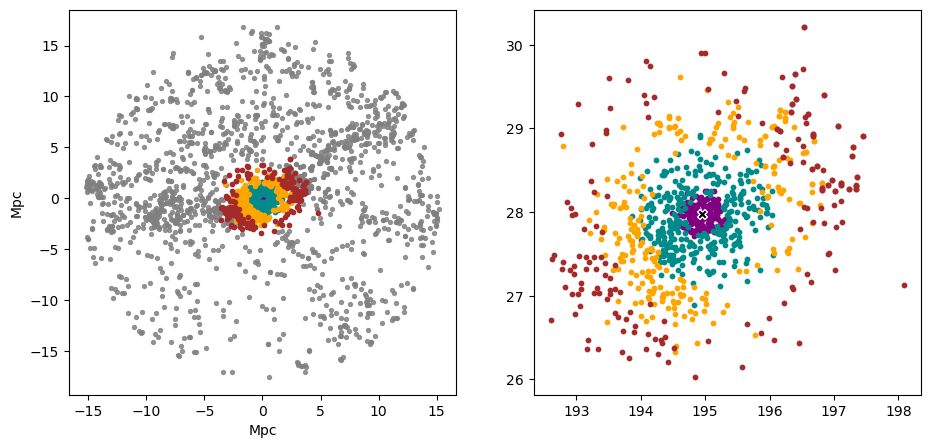

In [110]:
#clip = t[abs(t['V_pec']) <= (3*sigma_bi)]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5)) 

ax1.scatter(clip['X_'], clip['Y_'], s=8, color='gray', alpha=0.8)
ax1.scatter(c_in['X_'], c_in['Y_'], s=9, c='purple')
ax1.scatter(c_md['X_'], c_md['Y_'], s=9, c='darkcyan')
ax1.scatter(c_pe['X_'], c_pe['Y_'], s=9, c='orange')
ax1.scatter(c_ex['X_'], c_ex['Y_'], s=9, c='brown')
#ax1.scatter(c_ra, c_de, s=50, ec='white', fc='black', marker='X')
#cbar1.set_label('dV')
ax1.set_xlabel('Mpc')
ax1.set_ylabel('Mpc')

ax2.scatter(c_in['ra'], c_in['dec'], s=10, c='purple')
ax2.scatter(c_md['ra'], c_md['dec'], s=10, c='darkcyan')
ax2.scatter(c_pe['ra'], c_pe['dec'], s=10, c='orange')
ax2.scatter(c_ex['ra'], c_ex['dec'], s=10, c='brown')
ax2.scatter(c_ra, c_de, s=50, ec='white', fc='black', marker='X')

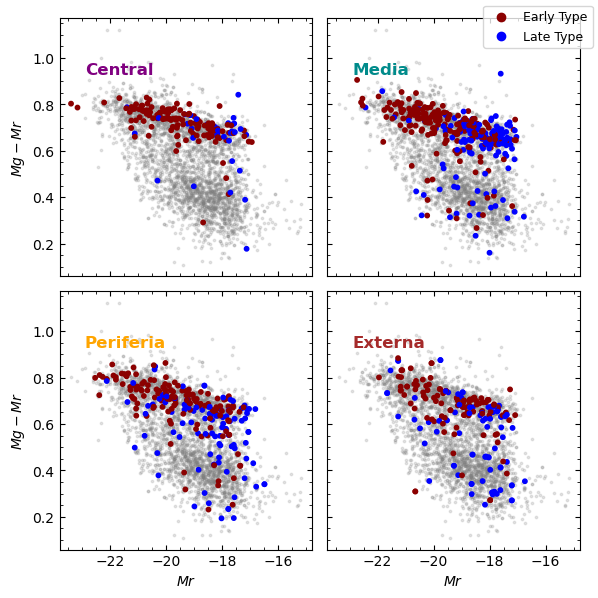

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'brown']
labels = ['Central', 'Media', 'Periferia', 'Externa']

for ax, table, color, label in zip(axes.flat, tables, colors, labels):
    ax.scatter(t['Mr'], t['gr'], s=3, c='gray', alpha=0.2)
    ax.scatter(table['Mr'], table['gr'], s=10, c=['darkred' if gt == 'Early' else 'blue' for gt in table['Galaxy_Type']])
    ax.text(0.1, 0.8, label, transform=ax.transAxes, ha='left', va='center', size=12, color=color, weight='bold')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True, direction='in')
    ax.tick_params(axis='y', which='both', right=True, direction='in')

axes[0, 0].set_ylabel(r'$Mg - Mr$')
axes[1, 0].set_ylabel(r'$Mg - Mr$')
axes[1, 0].set_xlabel(r'$Mr$')
axes[1, 1].set_xlabel(r'$Mr$')

# Creating invisible scatter plots for the legend
scatter_early = plt.scatter([], [], color='darkred', label='Early Type')
scatter_late = plt.scatter([], [], color='blue', label='Late Type')
# Adding the legend with fontsize parameter
fig.legend(handles=[scatter_early, scatter_late], loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

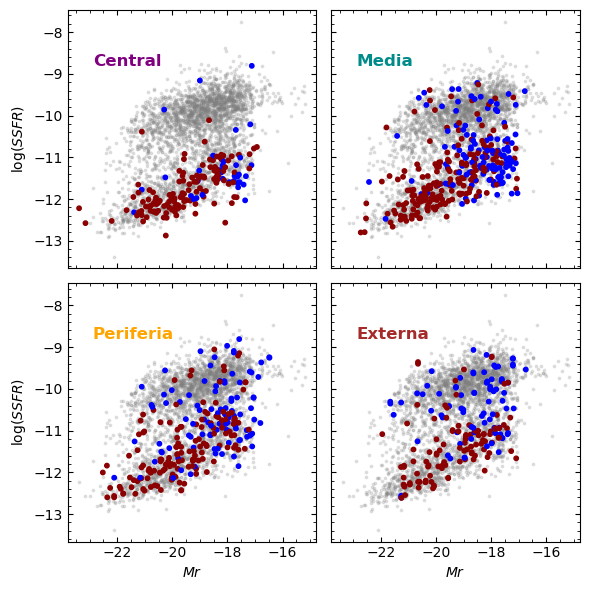

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'brown']
labels = ['Central', 'Media', 'Periferia', 'Externa']

for ax, table, color, label in zip(axes.flat, tables, colors, labels):
    ax.scatter(t['Mr'], t['logSSFR'], s=3, c='gray', alpha=0.2)
    ax.scatter(table['Mr'], table['logSSFR'], s=10, c=['darkred' if gt == 'Early' else 'blue' for gt in table['Galaxy_Type']])
    ax.text(0.1, 0.8, label, transform=ax.transAxes, ha='left', va='center', size=12, color=color, weight='bold')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True, direction='in')
    ax.tick_params(axis='y', which='both', right=True, direction='in')

axes[0, 0].set_ylabel(r'$\log (S SFR)$')
axes[1, 0].set_ylabel(r'$\log (S SFR)$')
axes[1, 0].set_xlabel(r'$Mr$')
axes[1, 1].set_xlabel(r'$Mr$')

# Creating invisible scatter plots for the legend
scatter_early = plt.scatter([], [], color='darkred', label='Early Type')
scatter_late = plt.scatter([], [], color='blue', label='Late Type')
# Adding the legend with fontsize parameter
#fig.legend(handles=[scatter_early, scatter_late], loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

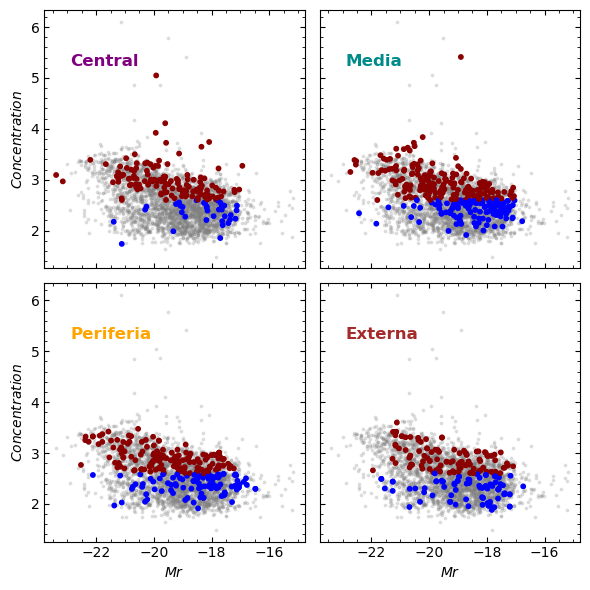

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'brown']
labels = ['Central', 'Media', 'Periferia', 'Externa']

for ax, table, color, label in zip(axes.flat, tables, colors, labels):
    ax.scatter(t['Mr'], t['C'], s=3, c='gray', alpha=0.2)
    ax.scatter(table['Mr'], table['C'], s=10, c=['darkred' if gt == 'Early' else 'blue' for gt in table['Galaxy_Type']])
    ax.text(0.1, 0.8, label, transform=ax.transAxes, ha='left', va='center', size=12, color=color, weight='bold')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True, direction='in')
    ax.tick_params(axis='y', which='both', right=True, direction='in')

axes[0, 0].set_ylabel(r'$Concentration$')
axes[1, 0].set_ylabel(r'$Concentration$')
axes[1, 0].set_xlabel(r'$Mr$')
axes[1, 1].set_xlabel(r'$Mr$')

# Creating invisible scatter plots for the legend
scatter_early = plt.scatter([], [], color='darkred', label='Early Type')
scatter_late = plt.scatter([], [], color='blue', label='Late Type')
# Adding the legend with fontsize parameter
#fig.legend(handles=[scatter_early, scatter_late], loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

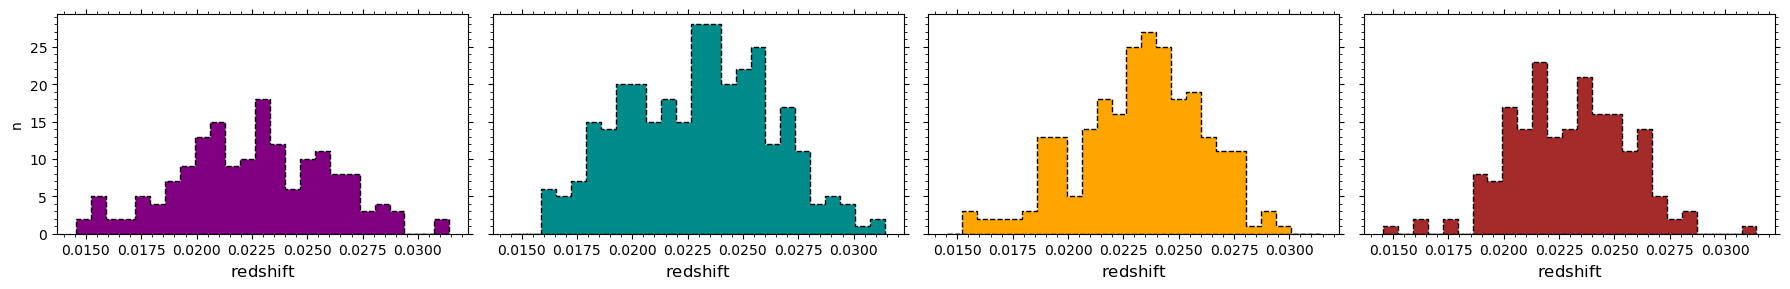

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['z'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\mathrm{redshift}$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

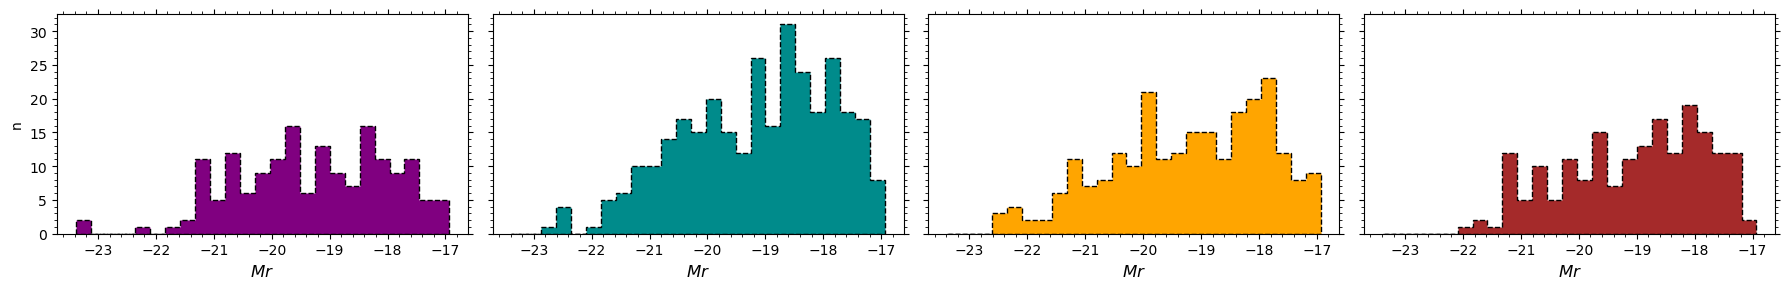

In [116]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['Mr'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$Mr$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

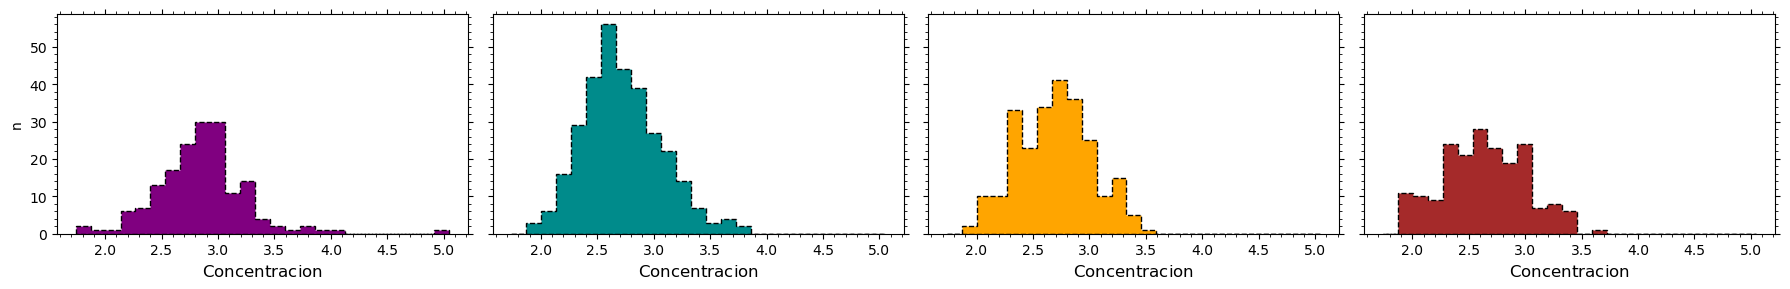

In [118]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['C'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\mathrm{Concentracion}$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

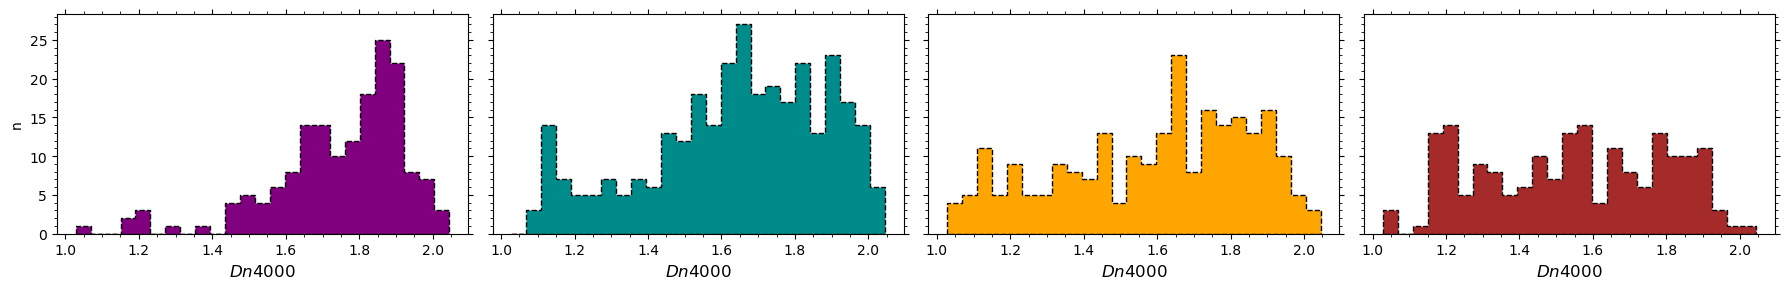

In [120]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['dn4000'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$Dn4000$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

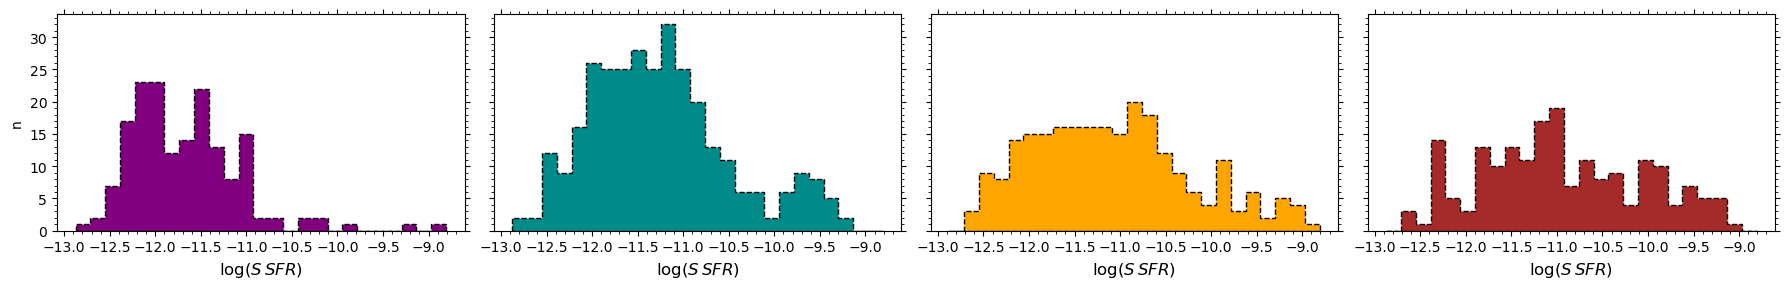

In [121]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['logSSFR'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\log(S\,SFR)$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

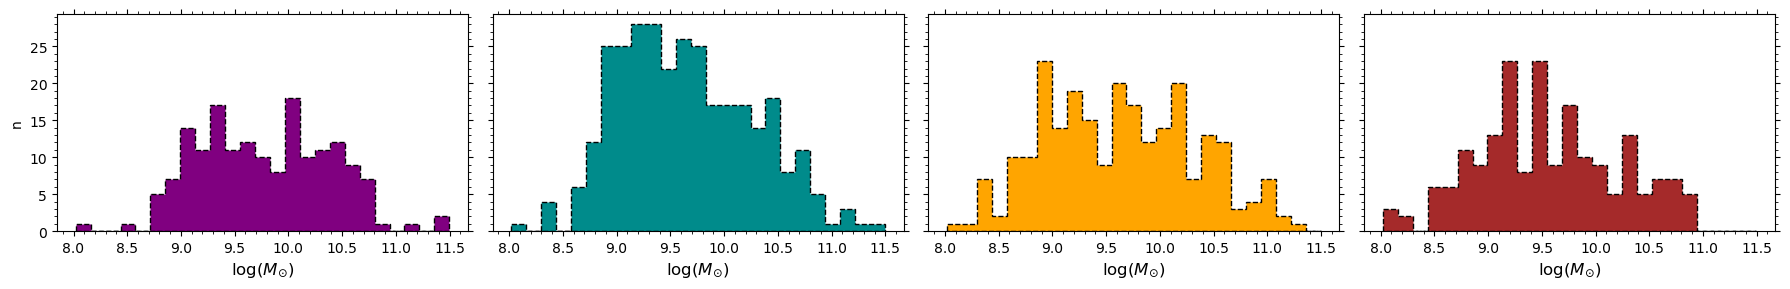

In [122]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['logSM'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\log(M_{\odot})$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

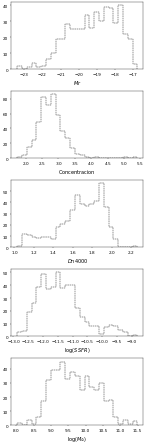

In [124]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(5,15), dpi=30)

h1 = ax1.hist(tc1['Mr'], bins=25, ec='black', histtype='step', linestyle='--')
ax1.set_xlabel(r'$Mr$', size=12)

h2 = ax2.hist(tc1['C'], bins=25, ec='black', histtype='step', linestyle='--')
ax2.set_xlabel(r'$\mathrm{Concentracion}$', size=12)

h3 = ax3.hist(tc1['dn4000'], bins=25, ec='black', histtype='step', linestyle='--')
ax3.set_xlabel(r'$Dn4000$', size=12)

h4 = ax4.hist(tc1['logSSFR'], bins=25, ec='black', histtype='step', linestyle='--')
ax4.set_xlabel(r'$\log(S\,SFR)$', size=12)

h5 = ax5.hist(tc1['logSM'], bins=25, ec='black', histtype='step', linestyle='--')
ax5.set_xlabel(r'$\log(M_{\odot})$', size=12)

plt.tight_layout()
#h21 = ax2.hist(c_in['C'], bins=25, fc='purple', histtype='stepfilled', linestyle='--')
#h22 = ax2.hist(c_md['C'], bins=h21[1], fc='darkcyan', histtype='stepfilled', linestyle='--', bottom=h21[0])
#h23 = ax2.hist(c_pe['C'], bins=h22[1], fc='orange', histtype='stepfilled', linestyle='--', bottom=h21[0]+h22[0])
#h24 = ax2.hist(c_ex['C'], bins=h23[1], fc='darkred', histtype='stepfilled', linestyle='--', bottom=h21[0]+h22[0]+h23[0])
#ax2.set_xlabel(r'$\mathrm{Concentracion}$', size=12)

In [198]:
a = int((len(c_in) * 5) / 100)
b = int((len(c_md) * 5) / 100)
c = int((len(c_pe) * 5) / 100)
d = int((len(c_ex) * 5) / 100)
sample_size = a + b + c + d

## Extract samples
#sample_in = c_in[np.random.choice(len(c_in), a, replace=False)]
#sample_md = c_md[np.random.choice(len(c_md), b, replace=False)]
#sample_pe = c_pe[np.random.choice(len(c_pe), c, replace=False)]
#sample_ex = c_ex[np.random.choice(len(c_ex), d, replace=False)]
#
## Combine the samples into one representative sample
#sample = vstack([sample_in, sample_md, sample_pe, sample_ex])
#MyID = np.linspace(1,44,44)
#sample_coord = Table([sample['ra'], sample['dec']])
##sample_coord.write('random_sample_coor.cat', format='ascii', overwrite=True)
#my_sample_coord = Table([sample['objID'],sample['ra'], sample['dec'], MyID])
##my_sample_coord.write('random_sample_coor_all.cat', format='ascii', overwrite=True)

Table.read('random_sample_coor_all.cat', format='ascii')

In [214]:
spec1 = fits.open('random_galaxies/1_spec-2241-54169-0502.fits')